# Классификация датасета ImageWoof 

В данной работе предлагается решение классификации датасета `ImageWoof`, выполненное техникой **Transfer learning**.

`ImageWoof` - это подмножество из 10 классов Imagenet, которые не так легко классифицировать, поскольку все они являются породами собак. Породы: Австралийский терьер, бордер-терьер, Самоед, Бигль, Ши-тцу, английский фоксхаунд, родезийский риджбек, Динго, золотистый ретривер, староанглийская овчарка (всего 10 классов).

Так как используется подход с дообучением нейронной сети, то поэтому задача с поиском оптимальных гиперпараметров частично отпадает, поэтому валидационная часть выборки одновременно будет и тестовой.


In [ ]:
# установка необходимых библиотек и фреймворков
!pip3 install torch torchvision tqdm numpy pandas matplotlib

In [ ]:
import os
import time
import tarfile
from shutil import rmtree
from tqdm.autonotebook import tqdm, trange
from random import choice

import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url
from torchvision import models, transforms

from warnings import filterwarnings
filterwarnings('ignore', module="matplotlib\..*")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [ ]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


# Загрузка и обработка данных 

In [ ]:
URL = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz"
ROOT = './'

In [ ]:
download_url(url=URL, root=ROOT)

data_path = os.path.join(ROOT, 'data')
with tarfile.open(os.path.join(ROOT, 'imagewoof2-320.tgz'), 'r:gz') as tar:
    if os.path.isdir(data_path):
        rmtree(data_path)
        
    tar.extractall(path=data_path)
    
os.remove('imagewoof2-320.tgz')

In [ ]:
DIR = os.path.join(ROOT, 'data', 'imagewoof2-320')

In [ ]:
labels = pd.read_csv(os.path.join(DIR, 'noisy_imagewoof.csv'))
labels.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


In [ ]:
data_path = {  # Путь до директории с соответсвующими выборками данных
    'train': os.path.join(DIR, 'train'),
    'val': os.path.join(DIR, 'val'),
}

data_transforms = {  # Аугментирование данных
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=40),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
}

datasets = {  # Удобная "обертка" для данных датасета из PyTorch
    data_type: torchvision.datasets.ImageFolder(
        root=data_path[data_type],
        transform=data_transforms[data_type]
    ) for data_type in ('train', 'val')
}

dataloaders = {  # "Загрузчик" данных для датасета
    data_type: torch.utils.data.DataLoader( 
    datasets[data_type],
    batch_size=128,
    shuffle=True,
    ) for data_type in ('train', 'val')
}

dataset_sizes = {data_type: len(x) for x, data_type in zip(datasets.values(), ['train', 'val'])}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


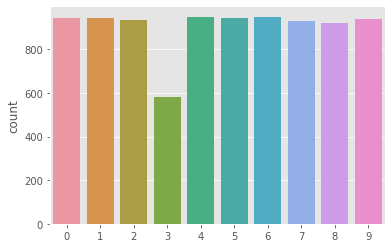

In [ ]:
sns.countplot(datasets['train'].targets);

Как видно, почти всех классов сбалансированное количество, это означает, что `accuracy` будет хорошей метрикой качетства.

Изобразим далее несколько объектов из датасета, дабы убедиться, что все в порядке с аугментацией, да и в принципе с данными.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


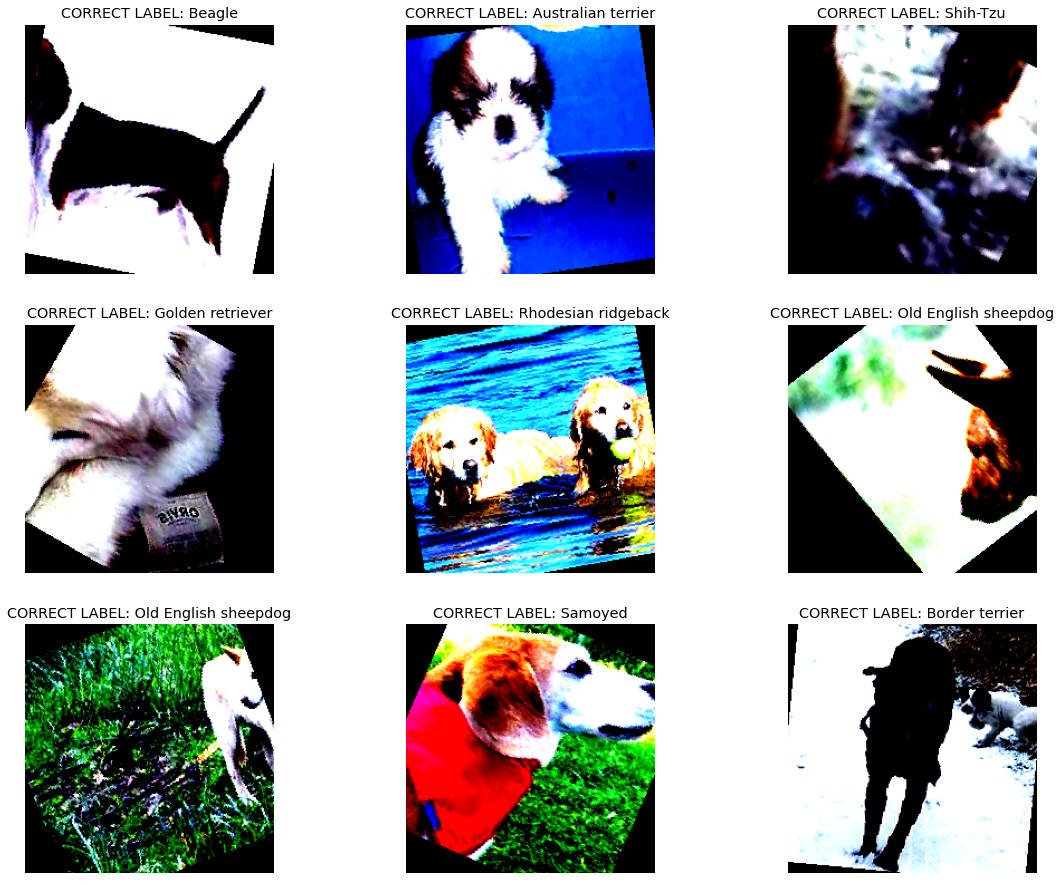

In [ ]:
NUM = 3
IMAGE_CLASSES = [
    'Australian terrier', 'Border terrier', 'Samoyed', 'Beagle', 'Shih-Tzu',
    'English foxhound', 'Rhodesian ridgeback', 'Dingo', 'Golden retriever', 'Old English sheepdog'
]

fig, ax = plt.subplots(NUM, NUM, figsize=(10, 10))
plt.subplots_adjust(left=NUM*(-0.2), bottom=NUM*(-0.1))

for i in range(NUM**2):
    data = choice(datasets['train'])
    image = data[0]
    class_number = data[1]
    
    ax[i // NUM, i % NUM].imshow((image.numpy().transpose(1, 2, 0)))
    ax[i // NUM, i % NUM].set_title(f'CORRECT LABEL: {IMAGE_CLASSES[class_number]}')
    ax[i // NUM, i % NUM].set_xticks([])
    ax[i // NUM, i % NUM].set_yticks([])
    ax[i // NUM, i % NUM].grid(False);

# Обучение модели

Далее создадим несколько функций для удобства обучения модели, а затем и для дальнейшего ее оценивания. Краткое объяснение их работы можно посмотреть в DocString (Google style).

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    '''
    Цикл тренировки модели

    Args:
        model: оптимизируемая модель
        criterion: функция потерь
        optimizer: алгоритм оптимизации модели
        scheduler: правило понижения learning rate для алгоритма оптимизации
        num_epochs: количество эпох тренировки

    Returns:
        model: натренированная модель
        losses: словарь из значений лосса на тренировочных данных и валидационных
        val_accuracy: список из значений accuracy на каждой эпохе
    '''
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    losses = {'train': [], "val": []}
    val_accuracy = []
    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # inputs <==> X, labels <==> y
                inputs, labels = data

                # переключаем на CPU или GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # обнуляем градиенты параметров
                if phase == "train":
                    optimizer.zero_grad()

                # forward-pass
                if phase == "val":
                    with torch.no_grad():
                        outputs = model(inputs)
                elif phase == 'train':
                    outputs = model(inputs)
                
                # берем только наиболее вероятный label
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                if phase == 'train':
                    scheduler.step()

                # вычисление лосса и метрики
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            if phase == 'val':
                val_accuracy.append(epoch_acc)

            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие параметры модели
    model.load_state_dict(best_model_wts)
    
    return model, losses, val_accuracy


In [ ]:
def evaluate_model(model):
    '''
    Функция оценки работы модели

    Args:
        model: оцениваемая модель
        
    Returns:
        значение accuracy на тестовых данных
    '''
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # inputs <==> X, labels <==> y
        inputs, labels = data
        
        # переносим на gpu, если возможно
        inputs = inputs.to(device)
        labels = labels.to(device)
            
        # forward-pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    '''
    Функция, "замораживающая" вычисление градиента на всех слоях нейронной сети
 
    Args:
        model:  модель
        feature_extracting: флаг, надо ли замораживать или нет 
    '''
    for param in model.parameters():
        if feature_extracting:
            param.requires_grad = False
        
        else:
            param.requires_grad = True

## ResNet50

В этом разделе мы будем использовать предварительно обученную ResNet50, которая представляет собой 50-слойную нейронную сеть, предварительно обученную на классификационном наборе данных ImageNet 2012, состоящем из 1000 классов. Более подробную информацию о ResNet можно найти в оригинальной статье He et al. (2016): https://arxiv.org/pdf/1512.03385.pdf

Сперва, данная модель будет использоваться исключительно как feature extractor на протяжении 25 эпох обучения, а новой головой данной модели будет всего лишь линейный слой.

In [ ]:
model_resnet = models.resnet50(pretrained=True)

In [ ]:
set_parameter_requires_grad(model=model_resnet, feature_extracting=True)

In [ ]:
model_resnet.fc = nn.Sequential(
    nn.Linear(in_features=model_resnet.fc.in_features, out_features=len(IMAGE_CLASSES)),
)

model_resnet = model_resnet.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.fc.parameters(), lr=1e-2, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_resnet, loss_resnet, accuracy_resnet = train_model(model_resnet, criterion, optimizer, exp_lr_scheduler, num_epochs=25)


Training complete in 40m 24s
Best val Acc: 0.903029


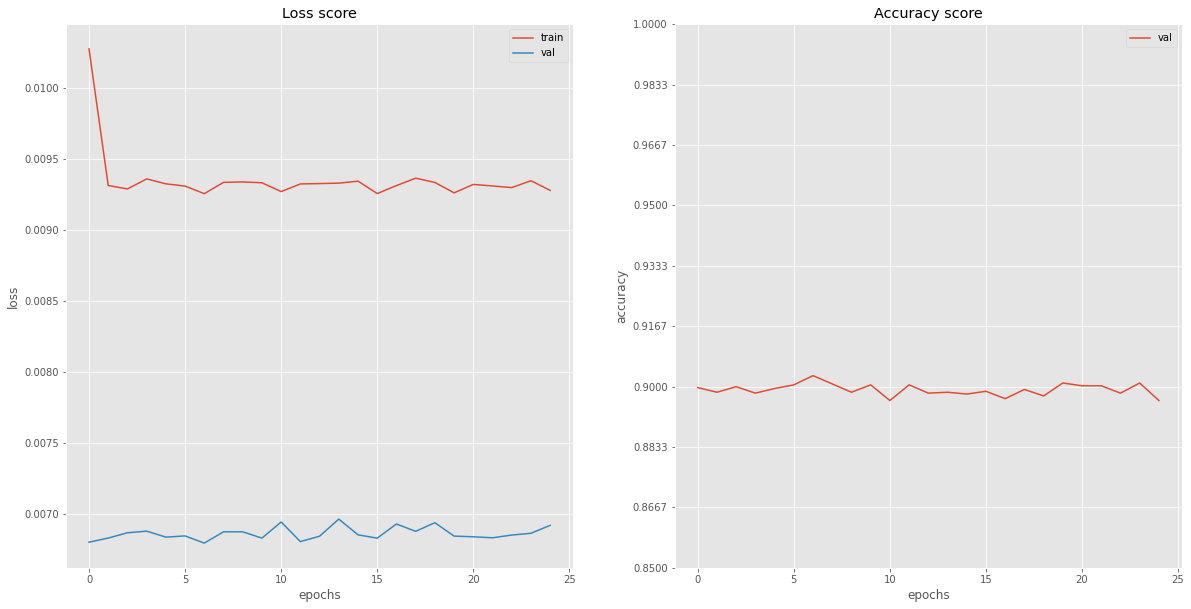

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(loss_resnet['train'], label='train')
ax[0].plot(loss_resnet['val'], label='val')
ax[0].set_title('Loss score')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(accuracy_resnet, label='val')
ax[1].set_title('Accuracy score')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].set_yticks(np.linspace(0.85, 1, 10))
ax[1].legend();

Судя по графикам, модель оооочень медленно училась (можно сказать, что вообще не училась), но я думаю это связано с тем, что мы обучали только один ее слой, а в таком случаее ее предел составляет не более 90% точности.

In [ ]:
score_resnet = evaluate_model(model_resnet)
print(f"ResNet accuracy: {score_resnet}")

ResNet accuracy: 0.8961567828964113


In [ ]:
torch.save(model_resnet.state_dict(), './first_stage.pth')

## Fine-tuning
Разморозим теперь все слои нейронной сети и попробуем пообучать сразу всё и вся. Но не все так просто: будем использовать техник с понижающимся learning rate от менее глубоких слоев к более. Это связано с тем, что в сверточных сетях первые слои обычно распознают наиболее общие паттерны, поэтому нам не очень сильно хочется в них что-то менять, в отличие уже от последующих, имеющих более специфическую задачу в плане распознавания.

In [ ]:
model_finetuning = models.resnet50(pretrained=False)
model_finetuning.fc = nn.Sequential(
    nn.Linear(in_features=model_resnet.fc.in_features, out_features=len(IMAGE_CLASSES)),
)
model_finetuning.load(torch.load('./first_stage.pth'))

model_finetuning = model_finetuning.to(device)

In [ ]:
set_parameter_requires_grad(model=model_finetuning, feature_extracting=False)

In [ ]:
optimizer_finetuning = optim.SGD(
    [
    {'params': model_finetuning.layer1.parameters()},
    {'params': model_finetuning.layer2.parameters()},
    {'params': model_finetuning.layer3.parameters(), 'lr': 1e-4},
    {'params': model_finetuning.layer4.parameters(), 'lr': 1e-4},
    {'params': model_finetuning.fc.parameters(), 'lr': 1e-2}
     ], lr=1e-5, momentum=0.9
)

exp_lr_scheduler_finetuning = optim.lr_scheduler.StepLR(optimizer_finetuning, step_size=10, gamma=0.1)

In [ ]:
model_finetuning, loss_finetuning, accuracy_finetuning = train_model(model_finetuning, criterion, optimizer_finetuning, exp_lr_scheduler_finetuning, num_epochs=20)


Training complete in 54m 9s
Best val Acc: 0.954441


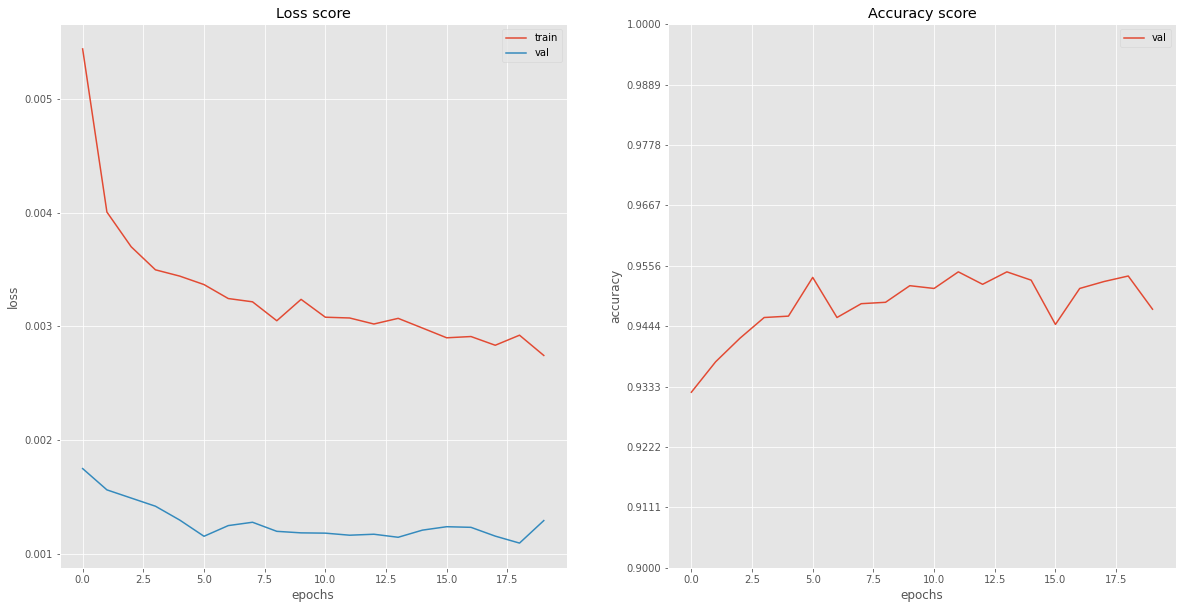

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(loss_finetuning['train'], label='train')
ax[0].plot(loss_finetuning['val'], label='val')
ax[0].set_title('Loss score')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend()

ax[1].plot(accuracy_finetuning, label='val')
ax[1].set_title('Accuracy score')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].set_yticks(np.linspace(0.9, 1, 10))
ax[1].legend();

Различие в лоссах (на валидации меньше, чем на трейне) скорее всего обусловлено тем, что тренировочная выборка аугментировалась, поэтому на валидации были уже априори более простые объекты. Аналогично было и при первом обучении модели.

In [ ]:
torch.save(model_finetuning.state_dict(), './second_stage.pth')